In [1]:
import pandas as pd
import seaborn as sns

from datetime import timedelta
from matplotlib import pyplot as plt
from plotting_utils import plotting_utils as pu

In [3]:
base_path = "data/case_study_base_anon.csv"
xs_path = "data/case_study_xs_anon.csv"

## 0. Summary of Key Insights

### 0.1 Customer Base Data EDA

After performing an exploration of the general data, we identified that there are NaN values in the operating_system column and 'undefined' values in the age_buckets column. We filled the NaN values for operating_system with 'undefined' and explored the 'undefined' groups for both variables as separate categories to understand how to treat them in the future

We calculated the historical Customer Lifetime Value of users as the sum of monthly commissions during the first 12 months of their subscription. The calculation was performed only for the observations with full information to do so (i.e., users for at least 12 months or already churned, for which the 12-month CLV has been crystalized). We noticed noisy data (observations with churn date previous to start date) for which the 12-month CLV resulted to be negative. As this is unintuitive and they comprised a small percentage of the data (<2%), we simply got rid of these data points. We additionally noticed several outliers in the 12-month CLV distributions, due to outliers in commission on the high end and in customer duration on the low end. We identified the outliers and analyzed them separately at the end


We performed several analyses for the rest of the data

We tried to understand the drivers of high commission and low duration (analysis [here](#drivers_clv12))

We also performed a customer segments analysis. With this goal, we split the users into CLV high, mid and low value cohorts based on the 12-month CLV historical quartiles and tried to profile them to understand relevant customer segments (analysis [here](#customer_cohorts_analysis)) 

The main insights are:

- product_c is associated to high commission but also early churn, it seems to depend on the other variables whether a customer that subscribed to this product becomes a high or low customer lifetime value (CLV) user
- channel_b and iOS channel seem to be associated with high 12-month clv
- channel_a and operating_system Android and undefined are potentially linked to low 12-month CLV
- users with start date in March or October seem to be associated with low 12-month CLV
- users in the 18-24 age_bucket are potentially associated to los 12-month CLV

We separately analyzed the outliers of the distribution of 12-month CLV values on both the high and low end (analysis can be found [here](#outliers_investigation))

### 0.2 Cross Sell Data EDA

Following a general exploration of the cross sell data, we noticed filled NaNs in the cross sell commission column and filled them with the median commission of each cross sell product. We then calculated the total cross sell CLV for each user as the sum of all their cross sell commission. Finally we joined the resulting cross sell dataset with the customer base data to access all the additional features

We analyzed several aspects of the resulting data

We tried to understand the drivers of high and low cross sell CLV (analysis [here](#drivers_of_cross_sell_CLV))

To perform a customer segments analysis, we split the users in the joined dataset into cross sell CLV high, mid and low value cohorts based on the cross sell CLV historical quartiles, and tried to profile them to gain customer insights. We additionally generated negative samples (i.e., extracted additional observations from the customer base dataset corresponding to users that did not convert to cross sell), to understand the composition of the non-converted users group (analysis can be found [here](#xs_cohort_analysis))

Our main insights are:
- higher 12-month CLV seems to be associated with a user converting to cross sell
- product_x is associated to higher cross sell CLV
- product_b is associated to lower cross sell CLV and lower general conversion to cross sell
- channel_b users seem to be more likely to convert to cross sell than channel_a users
- operating_system iOS correlates to higher cross sell CLV
- age_buckets 25-29 and 30-34 are associated to higher cross sell CLV
- ages 45+ are more associated to no conversion to cross sell

The full exploration and set of analyses can be followed from the next section onwards

## 1. Customer Base Dataset

### 1.1 General exploration

We start by exploring the Customer Base dataset. At first, we just want to look at the data and answer simple questions as:
- What variables do we have?
- How many observations?
- Are there missing values? If so, for which variables and how many?
- Are user_id's associated to more than one observation? If so, how (i.e. many products, many start dates and churns, many channels/OS's, etc.)

Read data:

In [4]:
df_base = pd.read_csv(base_path)

First peak at dataframe columns helps us to discover the available variables:

In [5]:
df_base.head()

,user_id,customer_started_at,customer_churned_at,product,commission,channel,age_bucket,operating_system
0,37d76d441d,2020-12-01,NaN,product_a,12.1775,channel_a,55+,iOS
1,cdc1327d79,2022-05-09,NaN,product_a,12.4575,channel_a,18-24,iOS
2,fac8c03aa8,2021-11-20,2023-01-01,product_c,21.6625,channel_a,35-39,Android
3,b0c703a998,2020-05-21,NaN,product_a,12.0475,channel_b,35-39,Android
4,0276bcc756,2021-04-15,NaN,product_c,15.7700,channel_b,35-39,Android


A first observation from looking at the first 5 rows of data is that the customer_churned_at column has NaN values. However, from the data description within the case instructions, we know this can be interpreted as the customer not having churned up to the present moment.

We will create an additional column 'is_active' to indicate this:

In [6]:
df_base["still_active"] = df_base["customer_churned_at"].isnull().astype(int)

In [7]:
df_base.head()

,user_id,customer_started_at,customer_churned_at,product,commission,channel,age_bucket,operating_system,still_active
0,37d76d441d,2020-12-01,NaN,product_a,12.1775,channel_a,55+,iOS,1
1,cdc1327d79,2022-05-09,NaN,product_a,12.4575,channel_a,18-24,iOS,1
2,fac8c03aa8,2021-11-20,2023-01-01,product_c,21.6625,channel_a,35-39,Android,0
3,b0c703a998,2020-05-21,NaN,product_a,12.0475,channel_b,35-39,Android,1
4,0276bcc756,2021-04-15,NaN,product_c,15.7700,channel_b,35-39,Android,1


Convert date columns to datetime:

In [8]:
df_base["customer_started_at"] =pd.to_datetime(df_base["customer_started_at"])

In [9]:
df_base["customer_churned_at"] =pd.to_datetime(df_base["customer_churned_at"])

We'll print some basic statistics about the dataframe next:

In [10]:
total_obs = len(df_base)
unique_cust = df_base["user_id"].unique().tolist()
min_start_date = df_base["customer_started_at"].min()
max_start_date = df_base["customer_started_at"].max()
min_end_date = df_base["customer_churned_at"].min()
max_end_date = df_base["customer_churned_at"].max()
avg_commision = df_base["commission"].mean()
products = df_base["product"].unique().tolist()
channels = df_base["channel"].unique().tolist()
age_buckets = df_base["age_bucket"].unique().tolist()
operating_systems = df_base["operating_system"].unique().tolist()

print(f"There are {total_obs} observations")
print(f"There are {len(unique_cust)} unique customers")
print(f"The minimum start date is {min_start_date}")
print(f"The maximum start date is {max_start_date}")
print(f"The minimum churn date is {min_end_date}")
print(f"The maximum churn date is {max_end_date}")
print(f"The average monthly commision is {avg_commision}")
print(f"The different products are: {products}")
print(f"The different channels are: {channels}")
print(f"The different age_buckets are: {age_buckets}")
print(f"The different operating_systems are: {operating_systems}")

There are 102623 observations
There are 102623 unique customers
The minimum start date is 2017-11-24 00:00:00
The maximum start date is 2023-05-31 00:00:00
The minimum churn date is 2017-12-23 00:00:00
The maximum churn date is 2024-01-01 00:00:00
The average monthly commision is 13.50081317053682
The different products are: ['product_a', 'product_c', 'product_b']
The different channels are: ['channel_a', 'channel_b']
The different age_buckets are: ['55+', '18-24', '35-39', '40-44', '25-29', '45-49', '30-34', '50-54', 'undefined']
The different operating_systems are: ['iOS', 'Android', nan, 'iPadOS', 'iPhone OS']


Some insights from the above:
- As there are as many unique customers as observations, it is implied that each unique_id is associated to only one observation
- Maximum churn date seems to be in 2024, we will assume that this is correct and that the analysis is taking place on 01-01-2024
- age_buckets column has values classified as 'undefined'
- operating_system column has NaN values

Let's understand the presence of 'undefined' and NaN in the age_buckets and operating_system columns more deeply:

In [11]:
num_age_bucket_undefined = len(df_base[df_base["age_bucket"]=="undefined"])
num_operating_system_nan = len(df_base[df_base["operating_system"].isnull()])

print(f"There are {num_age_bucket_undefined} observations ({num_age_bucket_undefined*100/total_obs}% of total) with 'undefined' age_bucket values")
print(f"There are {num_operating_system_nan} observations  ({num_operating_system_nan*100/total_obs}% of total) with operating_system NaN values")

There are 54 observations (0.05261978308956082% of total) with 'undefined' age_bucket values
There are 5883 observations  (5.732633035479376% of total) with operating_system NaN values


For age_bucket, 'undefined' values are only present for ~0.05% of the observations, which is very low.

In the case of operating_system, NaN values account for ~6% of observations. As this precentage is not negligible, we may have to think about handling the missing values appropriately.

However we will explore the data and how important each variable is for CLV further more before deciding how to do so.

To make sure that the other columns don't have any additional missing values, we run:

In [12]:
df_base[["user_id", "customer_started_at", "product", "commission", "channel", "age_bucket"]].isnull().values.any()

False

We convert the NaN values in the operating_system column to "undefined" to be able to explore their distribution and make a decision about what to do with them later on

In [13]:
df_base.loc[df_base["operating_system"].isnull(), "operating_system"] = "undefined"

### 1.2 Historical 12-month CLV

The dataset contains monthly commission data, based on which we can calculate the 12-month CLV for a given customer, defined as the sum of monthy commissions during the first 12 months of a customer.

To be able to compute the historical 12-month CLV, we fill the NaTs in the customer_churned_at column with the latest churn date (max_end_date), to be able to calculate the time since a customer joined us. We create an additional column, how_long_customer, that will contain the time since joining in days:

In [14]:
df_base["customer_churned_at"] = df_base.apply(lambda x: x.customer_churned_at if pd.isnull(x.customer_churned_at)==False else max_end_date, axis = 1)
df_base["how_long_customer"] =  df_base["customer_churned_at"] - df_base["customer_started_at"]

For the historical 12-month CLV computation, we assume we want to see customers that:
- have been with us for at least 12 months, or
- have already churned (i.e. no longe active)

To simplify the problem, customers that do not cover these conditions will be filtered out as we do not have complete information to calculate historical 12-month CLV for them

In [15]:
df_base_clv = df_base[(df_base["how_long_customer"]>=timedelta(365)) | (df_base["still_active"]==0)].reset_index(drop=True)

Let's see how many observations corresponding to customers with incomplete historical data to compute 12-month CLV will be dropped:

In [16]:
print(f"The are {total_obs - len(df_base_clv)} observations with incomplete historical data that will be dropped")

The are 9380 observations with incomplete historical data that will be dropped


Let's now compute 12-month historical CLV (clv_12) for the observations with complete data:

In [17]:
#Create capped duration (max 12 months in days) column
df_base_clv["how_long_customer_capped"] = df_base_clv.apply(lambda x: min(x.how_long_customer, timedelta(365)), axis = 1)

#Convert to float
df_base_clv["how_long_customer_capped"] = df_base_clv["how_long_customer_capped"].dt.total_seconds().astype(float)/(3600*24)

#Calculate clv_12
df_base_clv["clv_12"] = df_base_clv.apply(lambda x: x.commission*(x.how_long_customer_capped/(365/12)), axis = 1)

We create additional features to explore later:

In [18]:
df_base_clv["month_start"] = df_base_clv["customer_started_at"].dt.month
df_base_clv["day_start"] = df_base_clv["customer_started_at"].dt.weekday

In [19]:
df_base_clv.head()

,user_id,customer_started_at,customer_churned_at,product,commission,channel,age_bucket,operating_system,still_active,how_long_customer,how_long_customer_capped,clv_12,month_start,day_start
0,37d76d441d,2020-12-01,2024-01-01,product_a,12.1775,channel_a,55+,iOS,1,1126 days,365.0,146.13,12,1
1,cdc1327d79,2022-05-09,2024-01-01,product_a,12.4575,channel_a,18-24,iOS,1,602 days,365.0,149.49,5,0
2,fac8c03aa8,2021-11-20,2023-01-01,product_c,21.6625,channel_a,35-39,Android,0,407 days,365.0,259.95,11,5
3,b0c703a998,2020-05-21,2024-01-01,product_a,12.0475,channel_b,35-39,Android,1,1320 days,365.0,144.57,5,3
4,0276bcc756,2021-04-15,2024-01-01,product_c,15.7700,channel_b,35-39,Android,1,991 days,365.0,189.24,4,3


Let's do some simple visualizations of the clv_12 data:

<AxesSubplot:xlabel='clv_12', ylabel='Count'>

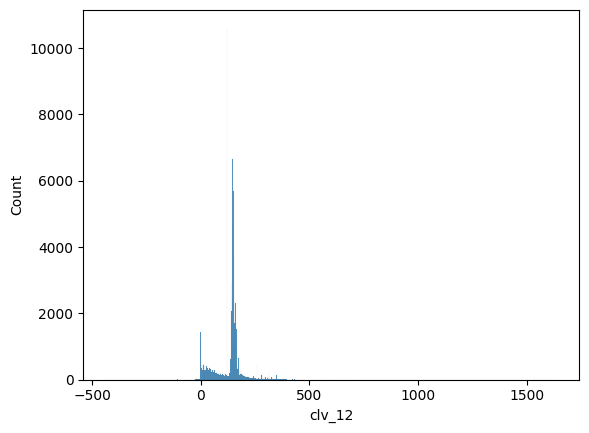

In [20]:
sns.histplot(data=df_base_clv, x="clv_12")

<AxesSubplot:ylabel='clv_12'>

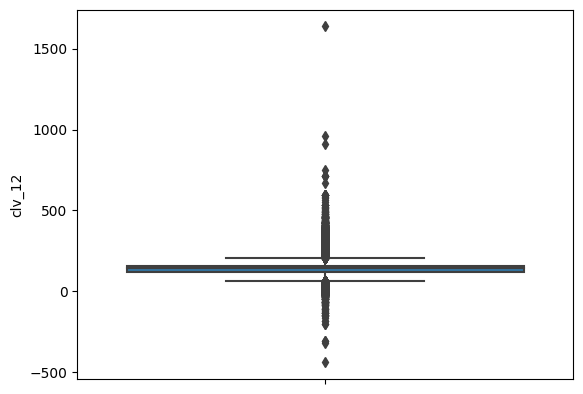

In [21]:
sns.boxplot(data=df_base_clv, y="clv_12")

Through the histogram and boxplot we notice the presence of outliers and, particularly strange, of clv_12 negative values. Let's take a closer look at the observations with negative clv_12 to understand what is causing them:

In [22]:
df_base_clv_negative = df_base_clv[df_base_clv["clv_12"]<0]

In [23]:
num_obs_base_clv_negative = len(df_base_clv_negative)
print(f"There are {num_obs_base_clv_negative} observations ({num_obs_base_clv_negative*100/total_obs}% of total) with negative clv_12")

There are 1559 observations (1.5191526266041726% of total) with negative clv_12


In [24]:
df_base_clv_negative.head()

,user_id,customer_started_at,customer_churned_at,product,commission,channel,age_bucket,operating_system,still_active,how_long_customer,how_long_customer_capped,clv_12,month_start,day_start
23,2be74ed2d0,2020-11-01,2020-10-21,product_c,11.7700,channel_b,30-34,iOS,0,-11 days,-11.0,-4.256548,11,6
119,e2a48eefd4,2019-08-19,2019-08-18,product_a,12.5575,channel_a,30-34,Android,0,-1 days,-1.0,-0.412849,8,0
164,248b96ed87,2022-02-10,2022-02-09,product_b,17.7700,channel_b,30-34,iOS,0,-1 days,-1.0,-0.584219,2,3
207,fd42d75ac6,2020-05-03,2020-05-02,product_a,11.5225,channel_b,40-44,iOS,0,-1 days,-1.0,-0.378822,5,6
211,22fa81cbc6,2019-08-09,2019-08-08,product_a,12.5575,channel_a,25-29,Android,0,-1 days,-1.0,-0.412849,8,4


It seems that the observations with negative clv_12 have a customer_churned_at date that pre-dates the customer_started_at date. This is unexpected behavior given the knowledge of the problem, as we would think that a customer can only churn after starting their relationship with Getsafe. Let's check if that is the case for all observations with negative clv_12:

In [25]:
len(df_base_clv_negative[df_base_clv_negative["customer_churned_at"]<df_base_clv_negative["customer_started_at"]])

1559

It seems that this condition is present in all data points with negative clv_12. Given the knowledge we have of the problem and data, and the fact that these negative clv_12 observation only account for less than 2% of the data, we will assume that these data points are noisy and will exclude them from future analysis

In [26]:
df_base_clv_non_neg = df_base_clv[df_base_clv["clv_12"]>=0].reset_index(drop=True)

Let's have an additional look at the observations with clv_12 = 0, to understand if there's any noise in these:

In [27]:
df_base_clv_0 = df_base_clv_non_neg[df_base_clv_non_neg["clv_12"]==0]

In [28]:
df_base_clv_0.head()

,user_id,customer_started_at,customer_churned_at,product,commission,channel,age_bucket,operating_system,still_active,how_long_customer,how_long_customer_capped,clv_12,month_start,day_start
38,3d48455640,2019-02-26,2019-02-26,product_a,10.0000,channel_b,30-34,Android,0,0 days,0.0,0.0,2,1
872,7cb312bae9,2018-11-20,2018-11-20,product_a,10.0000,channel_b,30-34,undefined,0,0 days,0.0,0.0,11,1
1188,15dbdc89f5,2018-03-15,2018-03-15,product_a,10.0000,channel_b,30-34,undefined,0,0 days,0.0,0.0,3,3
1548,6f98345330,2018-11-08,2018-11-08,product_a,10.0000,channel_b,55+,iOS,0,0 days,0.0,0.0,11,3
1725,d5495d8384,2020-02-22,2020-02-22,product_a,12.5575,channel_b,35-39,iOS,0,0 days,0.0,0.0,2,5


It seems that clv_12 is zero for observations where the customer churned on the same day as starting. This is expected behavior, so we conclude there is no noise and will continue to include these data points for our future analyses.

<a id='drivers_clv12'></a>

#### 1.2.1 Drivers of high and low 12-month historical CLV

Let's try to understand whether a high commission is associated to some of the other variables for the general data

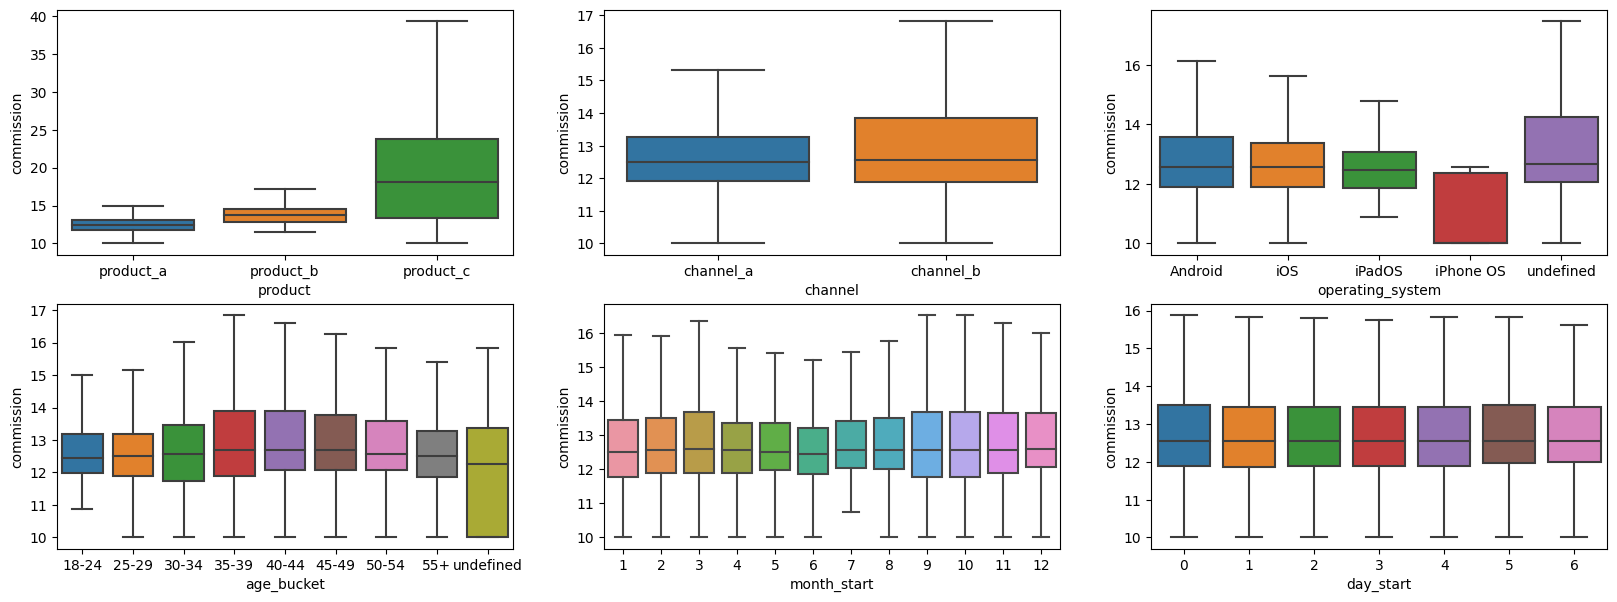

In [29]:
pu.box_plot_grid_x(data=df_base_clv_non_neg, x_list=["product", "channel", "operating_system", "age_bucket", "month_start", "day_start"], y="commission", showfliers=False)

The biggest indicative of a high commission seems to be:
- product: product_c
- channel: channel_b 
- operating_system: Android, undefined
- age_bucket: 35-39, 40-44, 45-49

Associated to a low commission are:
- product: product_a
- channel: channel_a
- operating_system: iPhone OS, iPadOS (slightly)
- age_bucket: undefined
- month_start: June (slightly)

Now let's try to understand the variables that can be associated to a low customer duration or early churn

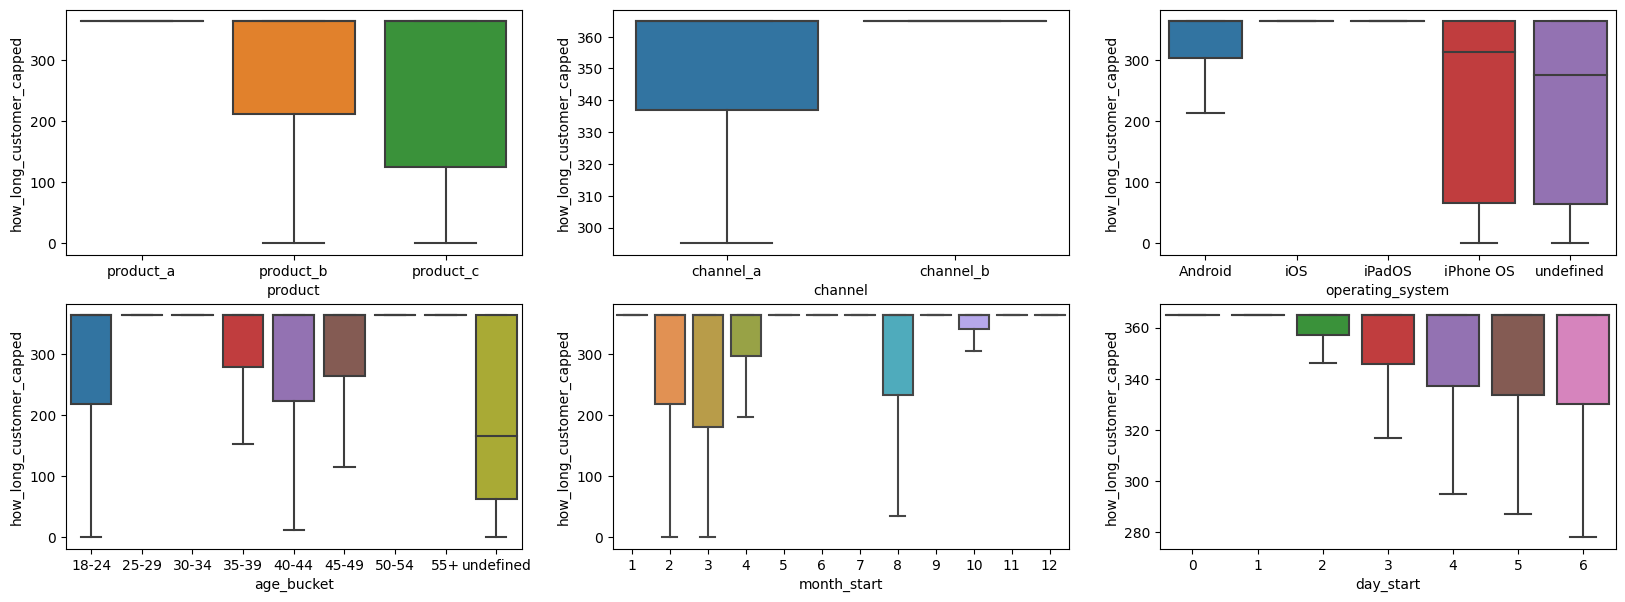

In [31]:
pu.box_plot_grid_x(data=df_base_clv_non_neg, x_list=["product", "channel", "operating_system", "age_bucket", "month_start", "day_start"], y="how_long_customer_capped", showfliers=False)

The following variables seem to correlate with low duration/early churn:
- product: product_c, product_b
- channel: channel_a
- operating_system: Android, iPhone OS, undefined
- age_bucket: undefined, 18-24, 40-44 and in lower degree 35-39, 45-49
- month_start: Feb-April, August and October (slightly)
- day_start: Tue-Sat (increasingly)

<a id='customer_cohorts_analysis'></a>

#### 1.2.2 Identifying relevant customer cohorts based on historical 12-month CLV

Let's try to identify the most relevant customer cohorts by segmenting the clv_12 values in 3 groups, high mid, and low value, based on the quartiles of the clv_12 distribution. We will filter out the outliers from this analysis

We first find the outliers using the interquantile range method and divide them into a high and low cohort that we'll have a look at later

In [32]:
Q1 = df_base_clv_non_neg['clv_12'].quantile(0.25)
Q2 = df_base_clv_non_neg['clv_12'].quantile(0.5)
Q3 = df_base_clv_non_neg['clv_12'].quantile(0.75)

#Calculate the IQR
IQR = Q3 - Q1

#Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Detect outliers
outliers_high = df_base_clv_non_neg[(df_base_clv_non_neg['clv_12'] > upper_bound)]
outliers_low = df_base_clv_non_neg[(df_base_clv_non_neg['clv_12'] < lower_bound)]
outliers = outliers_high.append(outliers_low)

We now define the non-outlier customer cohorts low and high

In [33]:
#Define non-outlier cohorts

#Low: below 0.25 quartile
df_base_clv_non_neg.loc[(df_base_clv_non_neg['clv_12'] >= lower_bound) & (df_base_clv_non_neg['clv_12'] < Q1), "cohort"] = "low"

#Mid: between 0.25 and 0.75 quartiles
df_base_clv_non_neg.loc[(df_base_clv_non_neg['clv_12'] >= Q1) & (df_base_clv_non_neg['clv_12'] < Q3), "cohort"] = "mid"

#High: above 0.75 quartile
df_base_clv_non_neg.loc[(df_base_clv_non_neg['clv_12'] >= Q3) & (df_base_clv_non_neg['clv_12'] < upper_bound), "cohort"] = "high"

df_base_clv_non_neg_cohorts = df_base_clv_non_neg[df_base_clv_non_neg["cohort"].isnull()==False]

Let's start analyzing the drivers of the clv_12 value of each of the cohorts

In [34]:
df_base_clv_non_neg_cohorts[df_base_clv_non_neg_cohorts["cohort"]=="high"][["commission", "how_long_customer_capped", "clv_12"]].describe()

,commission,how_long_customer_capped,clv_12
count,18115.000000,18115.000000,18115.000000
mean,14.177220,362.786310,168.393796
std,1.674592,16.678781,12.643458
min,13.040000,114.000000,156.480000
25%,13.347500,365.000000,160.170000
50%,13.637500,365.000000,163.650000
75%,14.482500,365.000000,173.772370
max,47.025000,365.000000,211.170000


In [35]:
df_base_clv_non_neg_cohorts[df_base_clv_non_neg_cohorts["cohort"]=="mid"][["commission", "how_long_customer_capped", "clv_12"]].describe()

,commission,how_long_customer_capped,clv_12
count,48151.000000,48151.000000,48151.000000
mean,11.866292,362.229133,140.742903
std,1.455210,17.826538,12.044332
min,10.000000,95.000000,120.000000
25%,11.590000,365.000000,136.290000
50%,12.175000,365.000000,145.080000
75%,12.557500,365.000000,150.060000
max,40.150000,365.000000,156.478685


In [36]:
df_base_clv_non_neg_cohorts[df_base_clv_non_neg_cohorts["cohort"]=="low"][["commission", "how_long_customer_capped", "clv_12"]].describe()

,commission,how_long_customer_capped,clv_12
count,6061.000000,6061.000000,6061.000000
mean,13.872417,213.438871,90.548473
std,4.620432,63.258604,15.918720
min,10.000000,34.000000,65.280658
25%,11.765000,174.000000,76.377123
50%,12.557500,212.000000,89.388082
75%,13.817500,255.000000,104.139616
max,89.180000,364.000000,119.997452


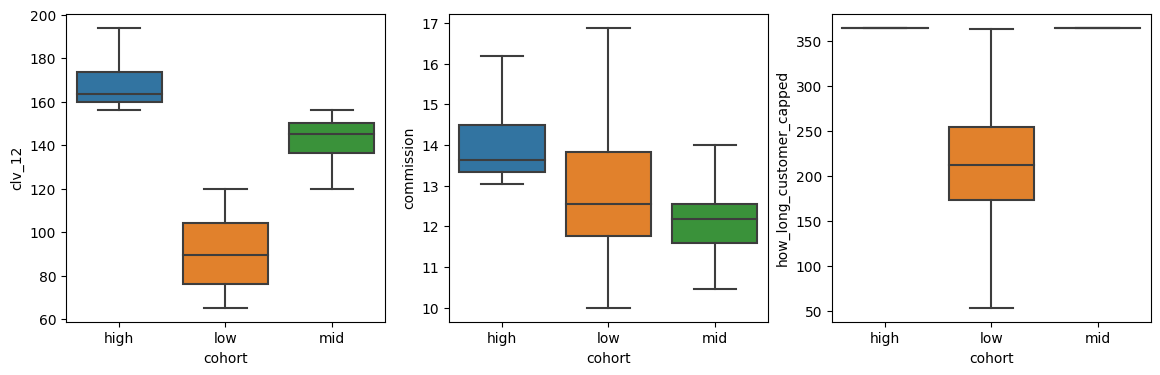

In [38]:
pu.box_plot_grid_y(df_base_clv_non_neg_cohorts, "cohort", ["clv_12", "commission", "how_long_customer_capped"], showfliers=False)

The higher clv_12 for the high value cohort seems to be driven mostly by higher commission and a lack of churn.

The lower clv_12 for the clv_12 low value cohort seems to be driven mostly by lower duration/high early churn

Let's see the distribution of the categorical variables in each of the clv_12 value cohorts, to see if we find relevant patterns. We will consider the mid value cohort as baseline to try to profile the other 2 value groups:

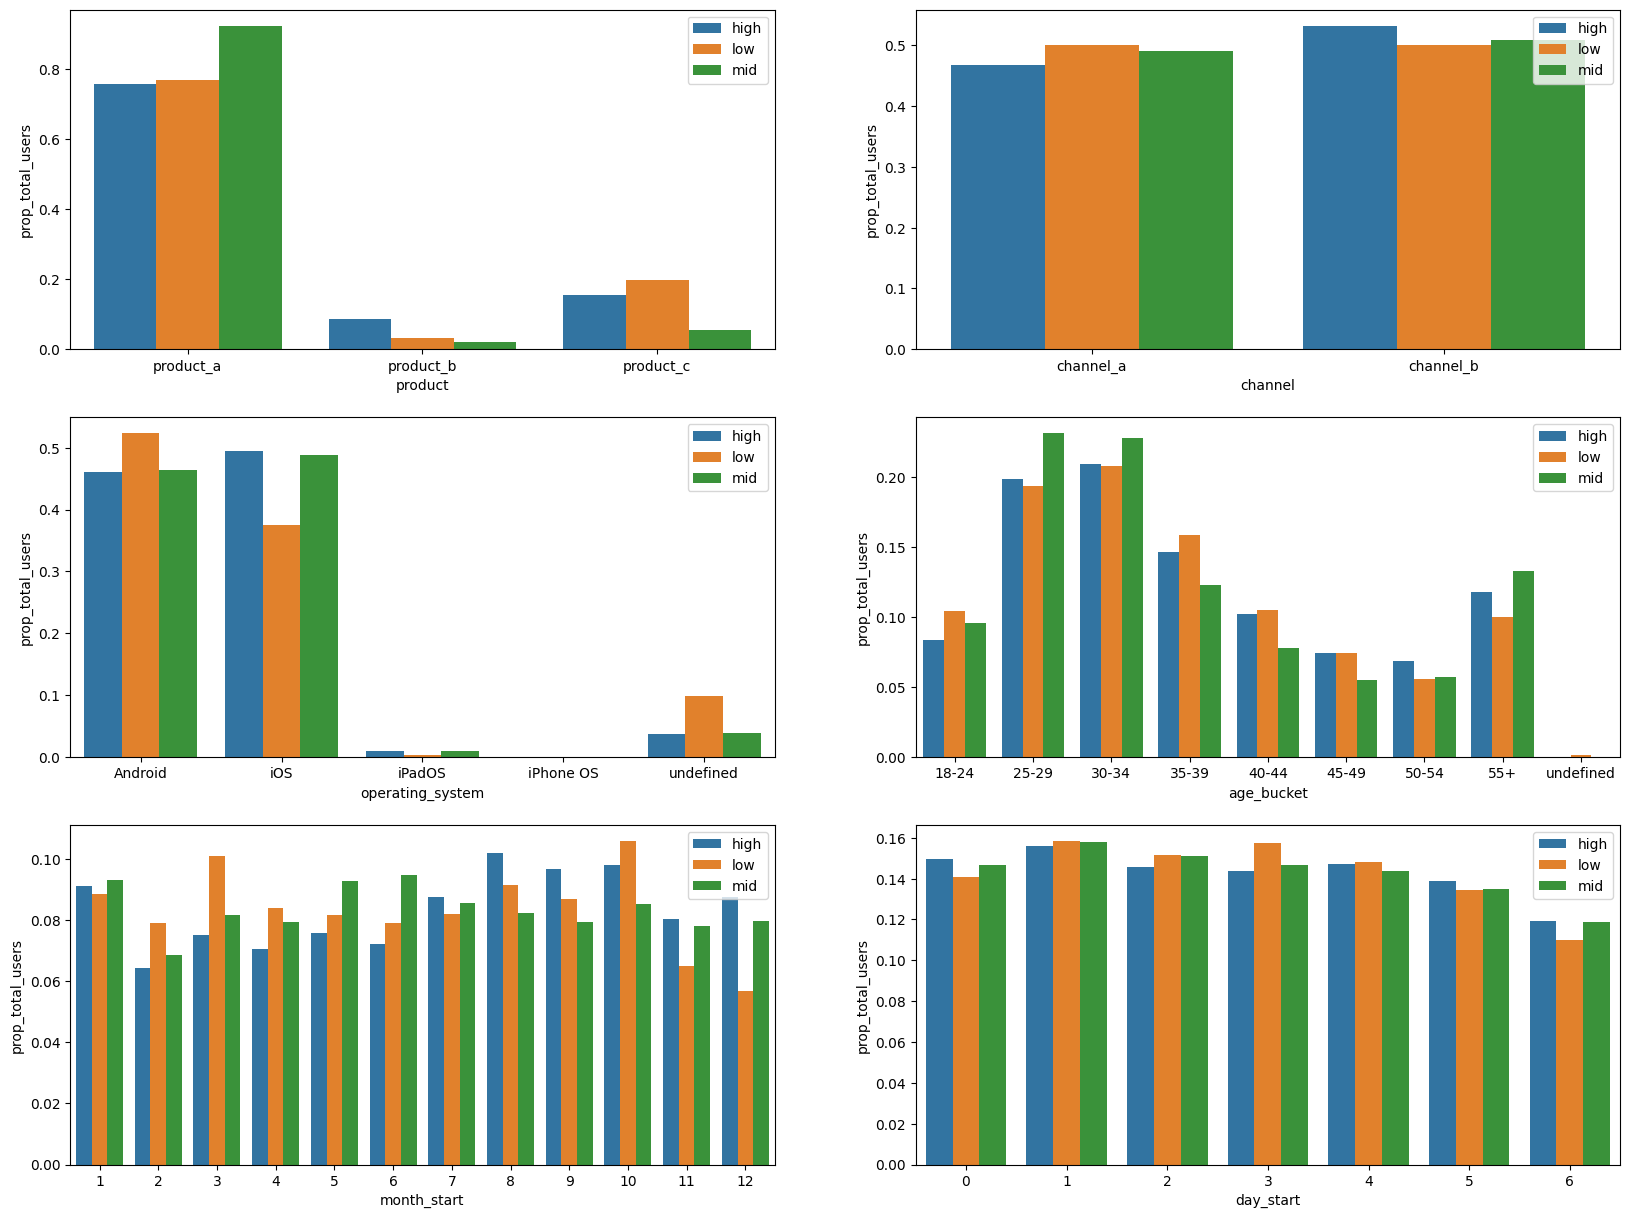

In [39]:
pu.barplot_grid(df_base_clv_non_neg_cohorts, x_list=["product", "channel", "operating_system", "age_bucket", "month_start", "day_start"], y="user_id", hue="cohort")

The  clv_12 high value cohort seems to have a higher proportion of product_b and product_c users than the mid value cohort, both associated with higher commission. Additionally, channel_b users (which also correlates to higher commisions) are slightly more prevalent in the clv_12 high value cohort than in the other ones. Customers in the high value group seem to start their contracts comparatively more between August-December and January vs the mid and low cohorts.

The clv_12 low value cohort seems to have an even higher proportion of product_c users, but channel_a seems to be slightly more prevalent for this group. Additionally, operating_system Android and undefined (both associated to low duration) are more prevalent within this group, while operating system iOS (associated to no churn) is less present proportionally vs the other 2. Additionally, there seems to be a slightly higher presence of customers that started their contract in March and October in this group, months which are associated to early churn. 18-24 age_bucket users seem to be more present in the low value cohort than in the other 2 groups

<a id='outliers_investigation'></a>

#### 1.2.3 Outliers investigation

We already discarded the outliers with negative values. However, many of the clv_12 outliers shown in the boxplot of the general clv_12 distribution on 1.2 have positive values, so we can't discard them automatically as noisy as we did with the negative ones. We will next try to further investigate these data points to gain more insights and decide how to handle them in the future

Let's understand how prevalent outliers are:

In [40]:
num_outliers = len(outliers)
print(f"There are {num_outliers} outliers ({num_outliers*100/total_obs}% of total obs) present in the data")

There are 19357 outliers (18.862243356752384% of total obs) present in the data


Outliers (after cutting out the ones with negative values) represent ~19% of the remaining data, which is a high proportion

We'll analyze separately the outliers with higher clv_12 (outliers_high) vs lower clv_12 (outliers_low) vs the data without outliers as baseline

In [41]:
#Data without outliers
df_base_clv_non_neg_non_out = df_base_clv_non_neg[df_base_clv_non_neg["user_id"].isin(outliers["user_id"].unique())==False]

In [42]:
#Outliers high numerical data summary
outliers_high[["commission", "how_long_customer_capped", "clv_12"]].describe()

,commission,how_long_customer_capped,clv_12
count,4808.000000,4808.000000,4808.000000
mean,23.876391,361.805116,283.585218
std,5.031836,16.484161,59.565487
min,17.602500,114.000000,211.230000
25%,20.575000,365.000000,243.120000
50%,23.415000,365.000000,279.600000
75%,25.967500,365.000000,309.405000
max,136.407500,365.000000,1636.890000


In [43]:
#Baseline numerical data summary
df_base_clv_non_neg_non_out[["commission", "how_long_customer_capped", "clv_12"]].describe()

,commission,how_long_customer_capped,clv_12
count,72327.000000,72327.000000,72327.000000
mean,12.613200,349.900065,143.462047
std,2.240042,48.164546,23.517704
min,10.000000,34.000000,65.280658
25%,11.771250,365.000000,136.290000
50%,12.457500,365.000000,146.760000
75%,13.195000,365.000000,156.510000
max,89.180000,365.000000,211.170000


In [44]:
#Outliers low numerical data summary
outliers_low[["commission", "how_long_customer_capped", "clv_12"]].describe()

,commission,how_long_customer_capped,clv_12
count,14549.000000,14549.000000,14549.000000
mean,14.231234,63.341123,28.092427
std,4.452180,47.294148,19.383630
min,10.000000,0.000000,0.000000
25%,12.175000,24.000000,10.734082
50%,12.707500,60.000000,26.874247
75%,14.232500,95.000000,44.004822
max,62.497500,198.000000,65.269233


In [45]:
#Create df for cohort analysis
df_base_clv_non_neg_non_out["cohort"] = "base"
outliers_high["cohort"] = "outliers_high"
outliers_low["cohort"] = "outliers_low"
df_base_clv_outliers_analysis = df_base_clv_non_neg_non_out.append(outliers_high)
df_base_clv_outliers_analysis = df_base_clv_outliers_analysis.append(outliers_low)

/home/jupyter/venvs/gs/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jupyter/venvs/gs/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jupyter/venvs/gs/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

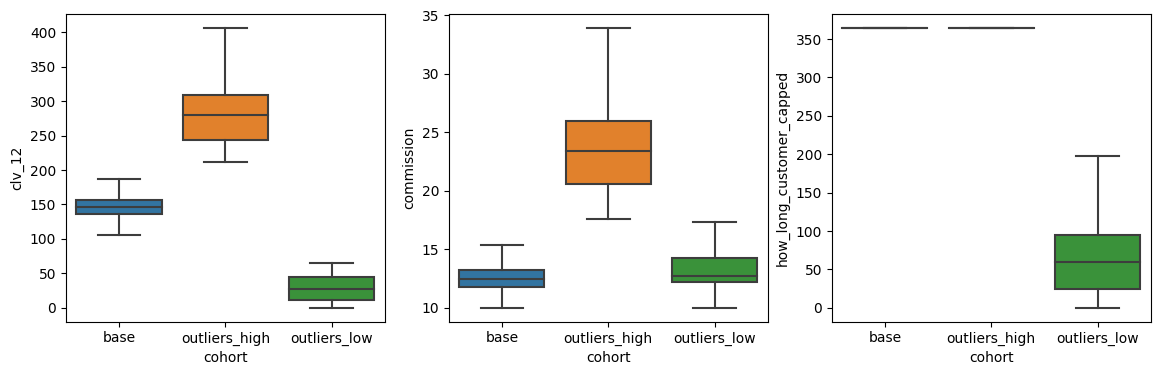

In [47]:
pu.box_plot_grid_y(df_base_clv_outliers_analysis, "cohort", ["clv_12", "commission", "how_long_customer_capped"], showfliers=False)

The higher clv_12 for the outliers_high cohort seems to be driven mostly by higher commission

The lower clv_12 for the outliers_low cohort seems to be driven mostly by lower customer duration. It's also relevant to note that all customers in this cohort have churned (longest duration is 7 months=198 days)

Now let's have a look at the distribution of the categorical variables for each of the groups

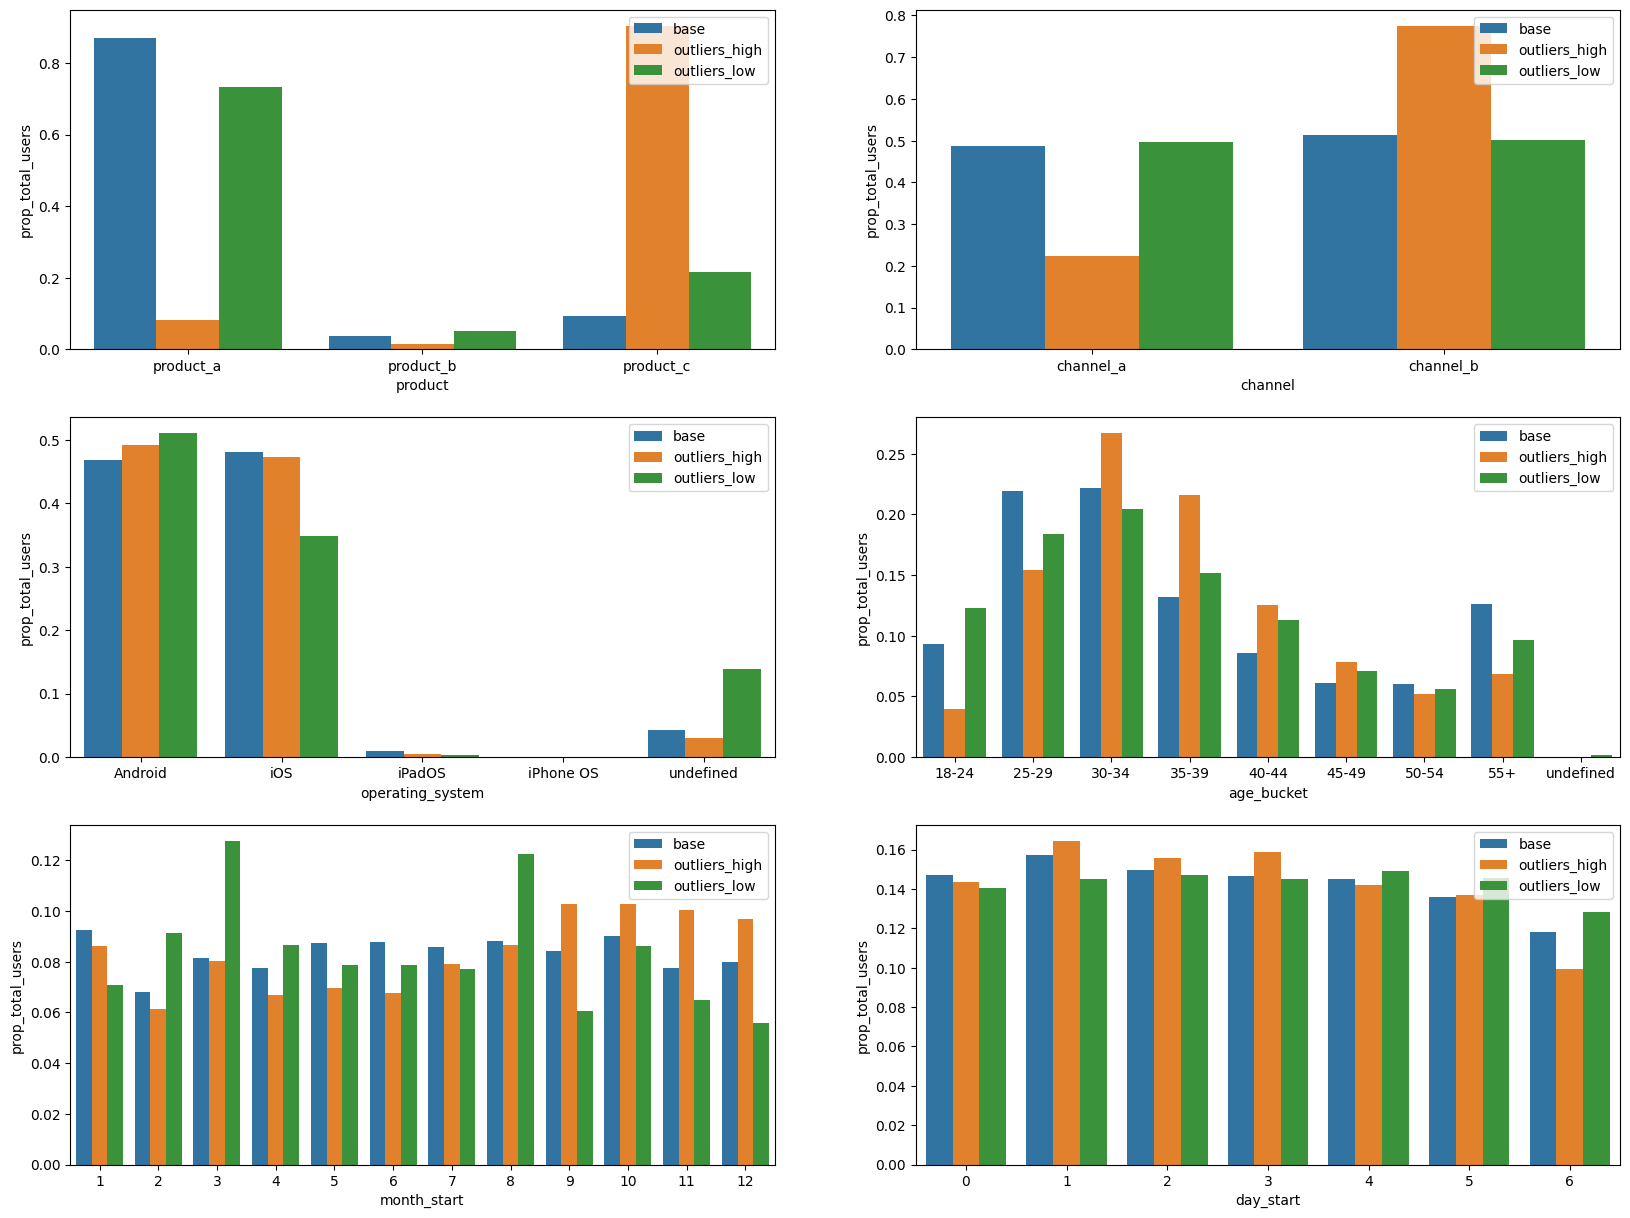

In [48]:
pu.barplot_grid(df_base_clv_outliers_analysis, x_list=["product", "channel", "operating_system", "age_bucket", "month_start", "day_start"], y="user_id", hue="cohort")

outliers_high analysis:

- The outliers_high cohort seems to be mainly populated by product_c users vs product_a in the other cohorts. 
- channel_b users (which also correlate to higher commisions) are proportionally more prevalent in the outliers_high cohort than in the rest of the data
- There's a lower proportion of users on the 18-24 and 25-29 age_bucket groups (associated to lower commission and/or duration) in the high cohort, and a higher proportion of users in the 30-34 and 35-39 groups (associated to high duration and high commission respectively)
- There's a higher proportion of users starting their contract from September to December (months associated with higher duration) in the high cohort

outliers_low analysis: 

- Users with operating_system Android and undefined (associated to lower duration) are proportionally more present in the outliers_low group, while operating_system iOS (associated to higher duration) is proportionally less present. 
- product_c is also more prevalent in this group vs the base data (associated with a lower duration), although product_a comprises the majority of the observations in the outliers low group
- Users starting their contracts in March and August (associated to early churn) have also a higher proportion within the outliers low cohort group
- 18-24 users (associated to low duration) are more prevalent in the outliers low group vs the other 2 cohorts

### 1.3 Commission through time

We'll try to see if there has been any changes of commission through time. We obsere a drop between 2018 and 2019, followed by an increase before 2020 and then noisy ups and downs. We would need to get additional information about the commission data and how commissions are determined in general to understand if we need to handle it in a particular way, i.e. adjusting for inflation, etc.

<AxesSubplot:xlabel='customer_started_at', ylabel='commission'>

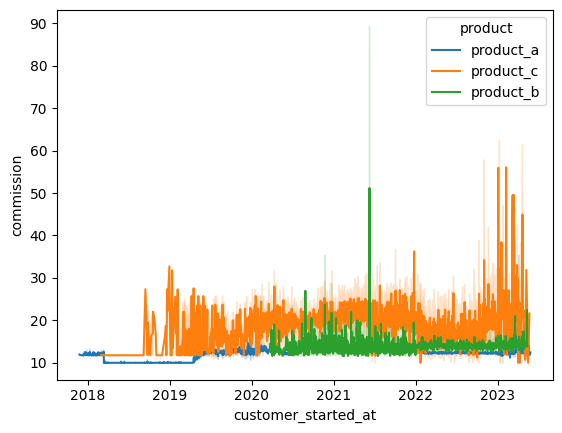

In [49]:
sns.lineplot(data=df_base_clv_non_neg, x="customer_started_at", y="commission", hue="product")

<AxesSubplot:xlabel='customer_started_at', ylabel='commission'>

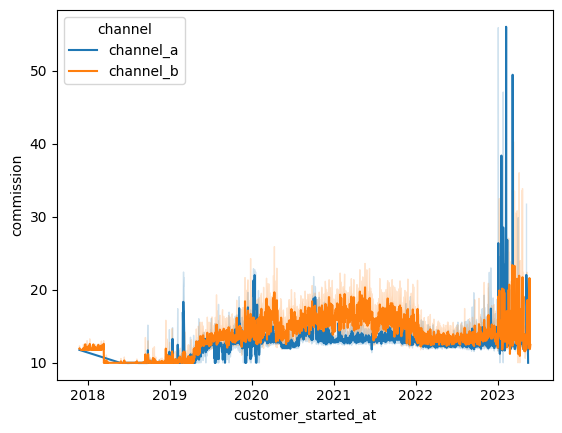

In [50]:
sns.lineplot(data=df_base_clv_non_neg, x="customer_started_at", y="commission", hue="channel")

<AxesSubplot:xlabel='customer_started_at', ylabel='commission'>

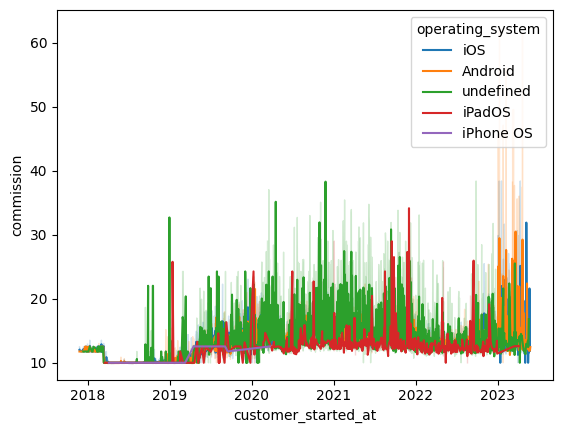

In [51]:
sns.lineplot(data=df_base_clv_non_neg, x="customer_started_at", y="commission", hue="operating_system")

## 2. Cross Sell Dataset

### 2.1 General Exploration

We'll now move on to exploring the Cross Sell dataset. As we did for the Customer Base data, at first we just want to look at the data and answer simple questions as:
- What variables do we have?
- How many observations?
- Are there missing values? If so, for which variables and how many?
- Are user_id's associated to more than one observation? If so, how (i.e. many products, many start dates and churns, many channels/OS's, etc.)

Read data (from here onwards, we will use "xs" to refer to the cross sell data and variables):

In [162]:
df_xs = pd.read_csv(xs_path)

First peak at dataframe columns helps us to discover the available variables:

In [163]:
df_xs.head()

,user_id,product,commission,date
0,ccc05d82e1,product_y,499.6000,2022-08-05
1,77a488f223,product_y,821.2950,2022-10-20
2,e717cb5a0b,product_y,1215.0350,2023-01-19
3,1e9ca78b5b,product_y,413.1800,2022-12-20
4,eee1f85c5c,product_y,354.4475,2022-10-06


Convert date column to datetime:

In [164]:
df_xs["date"] =pd.to_datetime(df_xs["date"])

We'll print some basic statistics about the dataframe next:

In [165]:
total_obs_xs = len(df_xs)
unique_xs_cust = df_xs["user_id"].unique().tolist()
xs_custs_in_df_base = df_xs[df_xs["user_id"].isin(df_base["user_id"].unique())]["user_id"].unique().tolist()
min_start_date_xs = df_xs["date"].min()
max_start_date_xs = df_xs["date"].max()
avg_commision_xs = df_xs["commission"].mean()
products_xs = df_xs["product"].unique().tolist()

print(f"There are {total_obs_xs} observations")
print(f"There are {len(unique_xs_cust)} unique customers")
print(f"{len(xs_custs_in_df_base)} xs unique customers are in the customer base dataset")                                            
print(f"The minimum start date is {min_start_date_xs}")
print(f"The maximum start date is {max_start_date_xs}")
print(f"The average monthly commision is {avg_commision_xs}")
print(f"The different products are: {products_xs}")

There are 1318 observations
There are 1143 unique customers
1143 xs unique customers are in the customer base dataset
The minimum start date is 2022-02-01 00:00:00
The maximum start date is 2023-06-06 00:00:00
The average monthly commision is 691.1569763033175
The different products are: ['product_y', 'product_x']


Some insights from the above:
- There are more observations than unique customers as observations, so a givne user may have bought more than 1 cross sell product
- All cross sell users are in the Customer Base dataset
- Dates comprise a shorter time period vs the timeframe of the Customer Base dataset's observations
- Cross Sell products are different from the Customer Base products, with a higher average commission

Let's see if there are any missing values:

In [166]:
df_xs.isnull().values.any()

True

All missing values seem to be for the commission column, which has 19% of observations (a high proportion) with missing values:

In [167]:
print(f"There are {len(df_xs[df_xs['user_id'].isnull()])} missing values for user_id")
print(f"There are {len(df_xs[df_xs['product'].isnull()])} missing values for product")
print(f"There are {len(df_xs[df_xs['commission'].isnull()])} ({len(df_xs[df_xs['commission'].isnull()])*100/total_obs_xs}% of total obs) missing values for commission")
print(f"There are {len(df_xs[df_xs['date'].isnull()])} missing values for date")

There are 0 missing values for user_id
There are 0 missing values for product
There are 263 (19.954476479514415% of total obs) missing values for commission
There are 0 missing values for date


### 2.2 Historical cross sell CLV

From the problem definition, we know that the cross sell CLV is equal to the payment of the second product as a one time value. Given this, there are 2 parts to estimating the cross sell CLV:
- Determine if a customer will convert to buying a cross sell product
- Determine the value of the cross sell commissions

Let's start by analyzing the variables that could help us to understand the cross sell commissions point, given that a customer has converted to cross sell. We'll quickly have a look at the distribution of commission for the new cross sell products (we'll change the variable name to clv_xs for CLV cross sell)

In [168]:
#Rename columns and, in particular, commission column as clv_xs = CLV cross sell
df_xs = df_xs.rename(columns={"product": "product_xs", "date": "date_xs", "commission": "clv_xs"})

To not miss out on the information of the observations with missing values, we will fill NaN clv_xs values with the median value for each cross sell product:

In [169]:
#Fill out clv_xs missing values with median of commission for each product
df_xs.loc[(df_xs["clv_xs"].isnull())&(df_xs["product_xs"]=="product_x"), "clv_xs"] = df_xs[df_xs["product_xs"]=="product_x"]["clv_xs"].median()
df_xs.loc[(df_xs["clv_xs"].isnull())&(df_xs["product_xs"]=="product_y"), "clv_xs"] = df_xs[df_xs["product_xs"]=="product_y"]["clv_xs"].median()

We additionally compute the total cross sell CLV by summing the value in all rows for a given user_id. We create an additional product category called "both" which indicates the customer buying both cross sell products. We keep the earliest date in which the customer converted to cross sell as date_xs

In [170]:
#Group by user_id to get total clv_xs for each user
df_xs_grouped = df_xs.groupby(["user_id"]).agg({"product_xs": list, "date_xs": "min", "clv_xs": "sum"}).reset_index()
df_xs_grouped["product_xs"] = df_xs_grouped.apply(lambda x: x.product_xs[0] if len(x.product_xs)==1 else "both", axis=1)

<AxesSubplot:ylabel='clv_xs'>

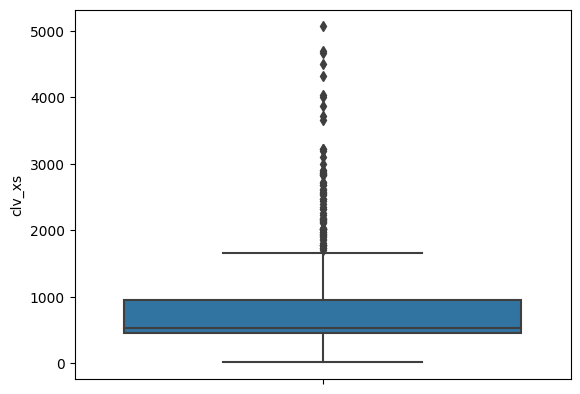

In [171]:
sns.boxplot(data=df_xs_grouped, y="clv_xs")

<AxesSubplot:xlabel='clv_xs', ylabel='Count'>

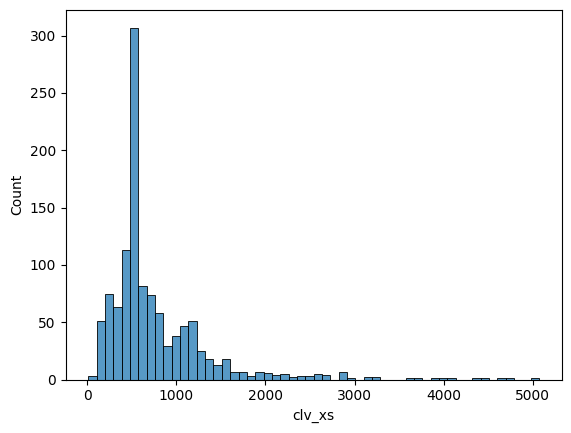

In [172]:
sns.histplot(data=df_xs_grouped, x="clv_xs")

The distribution of clv_xs has some outliers but not as many as we observed for the Customer Base data

Let's join the Cross Sell database with the Customer Base dataset to be able to use additional features for our analysis

In [173]:
#Join with base dataset without negative clv_12 observations
df_xs_with_base = df_xs_grouped.merge(df_base_clv_non_neg, on="user_id", how="inner")

We explore the relationship between clv_xs and clv_12. It is not so clear from the scatterplot

<AxesSubplot:xlabel='clv_12', ylabel='clv_xs'>

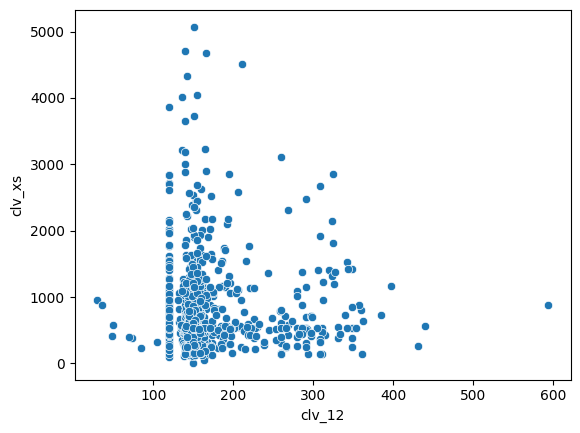

In [174]:
sns.scatterplot(data=df_xs_with_base, x="clv_12", y="clv_xs")

We will next look at the distribution of clv_xs for each of the categorical variables in the customer base dataset, to see if we can find any patterns

<a id='drivers_of_cross_sell_CLV'></a>

#### 2.2.1 Drivers of cross sell CLV

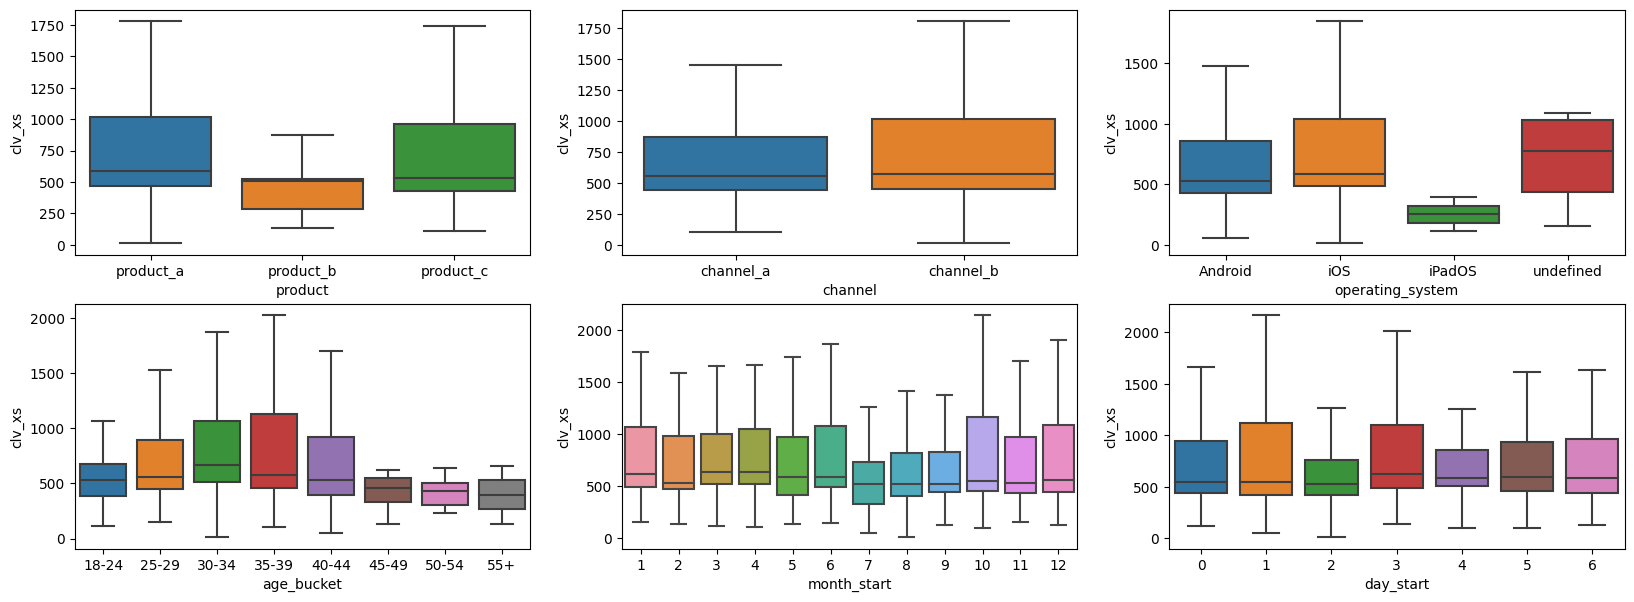

In [175]:
pu.box_plot_grid_x(data=df_xs_with_base, x_list=["product", "channel", "operating_system", "age_bucket", "month_start", "day_start"], y="clv_xs", showfliers=False)

Analysis:

- product_b is associated to a lower clv_xs
- channel_b is asociated to a higher clv_xs
- operating_system iOS and undefined seem to be associated to a higher clv_xs. iPadOS is associated to a lower clv_xs
- age_bucket 20-24 and 25-29 are associated to a higher clv_xs. 18-24 and >45 groups seem to be associated to a lowe clv_xs
- month_start July, August and September are associated with lower clv_xs
- day_start Tuesday and Thursdays seem to be associated with lower clv_xs

Now let's analyze the distribution of clv_xs for the categorical variables within the cross sell data. We will create additional feature columns corresponding to the month and day of the week when the customer converted to cross sel, as well as an additional continuous variable indicating the duration of the customer at the time of cross sell

In [176]:
#Create month and day variables
df_xs_with_base["date_xs"] = pd.to_datetime(df_xs_with_base["date_xs"])
df_xs_with_base["date_xs"] = pd.to_datetime(df_xs_with_base["date_xs"])
df_xs_with_base["month_xs"] = df_xs_with_base["date_xs"].dt.month
df_xs_with_base["day_xs"] = df_xs_with_base["date_xs"].dt.weekday

#Create duration at cross sell variable
df_xs_with_base["time_at_xs_since_start"] = df_xs_with_base["date_xs"]-df_xs_with_base["customer_started_at"]
df_xs_with_base["time_at_xs_since_start"] = df_xs_with_base["time_at_xs_since_start"].dt.total_seconds().astype(float)/(3600*24)

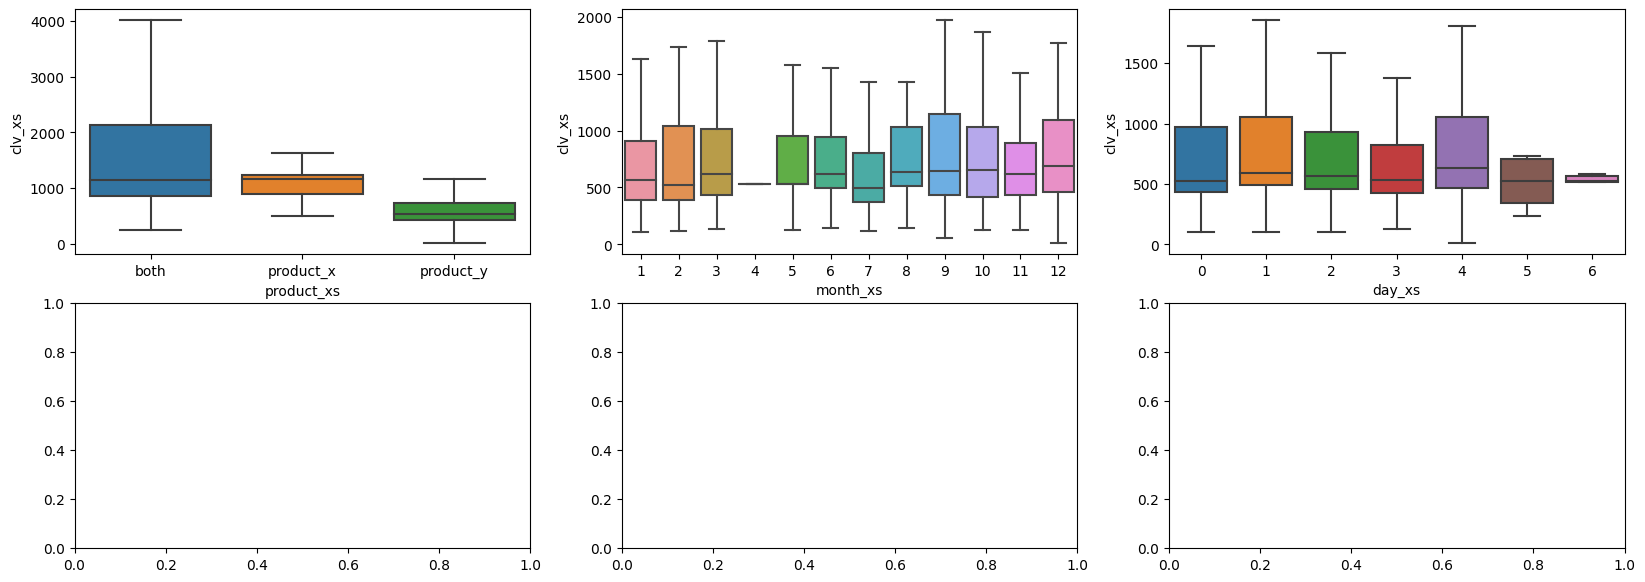

In [177]:
pu.box_plot_grid_x(data=df_xs_with_base, x_list=["product_xs", "month_xs", "day_xs"], y="clv_xs", showfliers=False)

Analysis:

- product_y is associated to a lower clv_xs, and customers who convert to both have the higher clv_xs
- month_xs April, July and November are associated to a lower clv_xs
- day_xs Saturday seems to be associated with lower clv_xs

We will now have a look at the duration of the customer at the time of cross sell, and its relationship with the other variables

No clear relationship is observed between clv_xs and duration at xs time

<AxesSubplot:xlabel='time_at_xs_since_start', ylabel='clv_xs'>

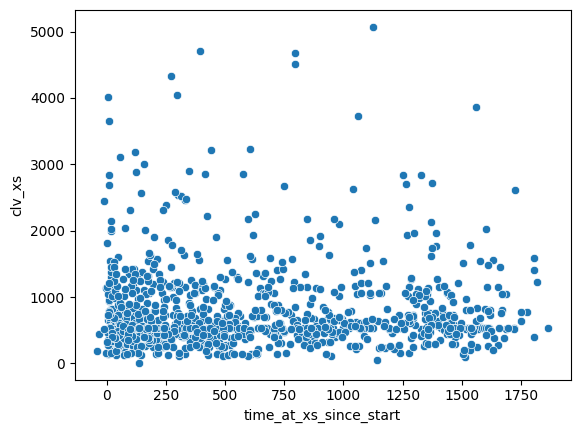

In [178]:
sns.scatterplot(data=df_xs_with_base, x="time_at_xs_since_start", y="clv_xs")

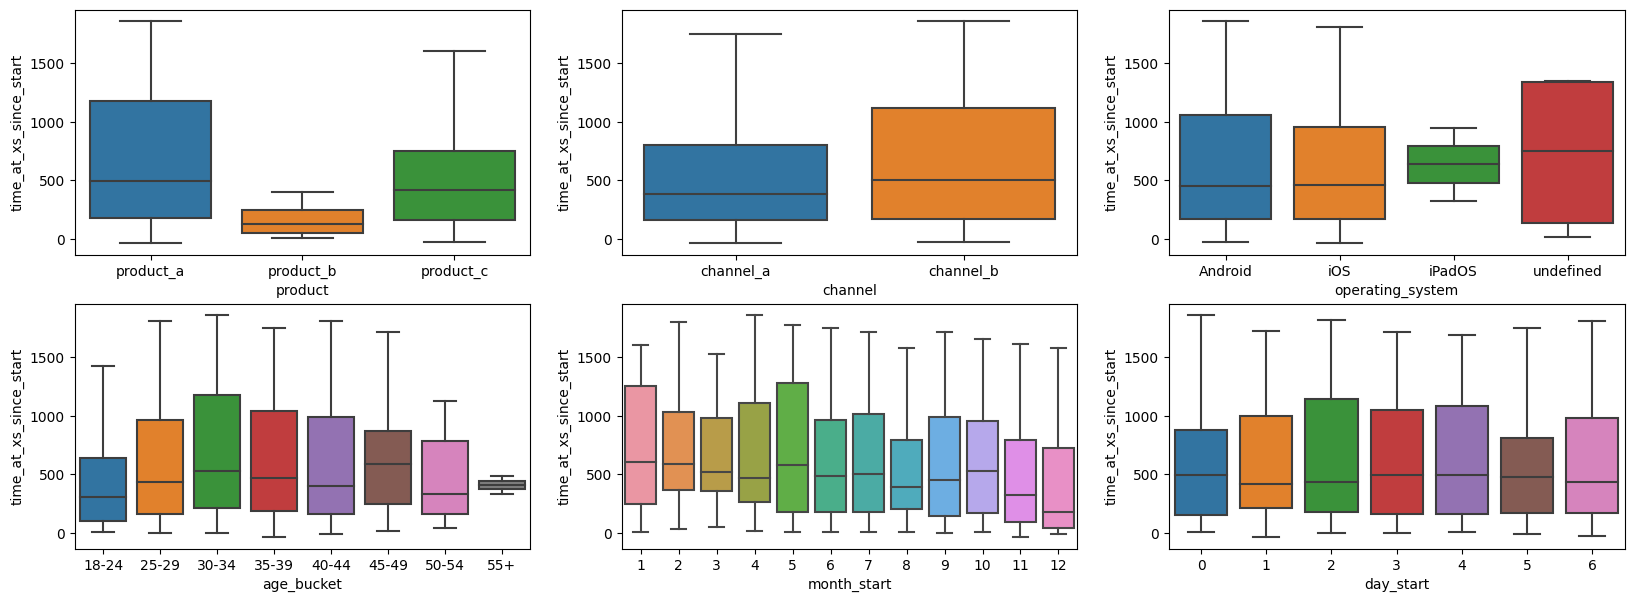

In [179]:
pu.box_plot_grid_x(data=df_xs_with_base, x_list=["product", "channel", "operating_system", "age_bucket", "month_start", "day_start"], y="time_at_xs_since_start", showfliers=False)

Analysis:

- product_b customers convert sooner to cross sell (associated to low time_at_xs_since_start), product_a are potentially associated with the slowest time
- channel_b seems to be associated to a higher time to cross sell conversion
- operating_system iPadOS and undefined have very different distributions of time to cross sell conversion vs the other 2 categories. undefined category associated to higher time to cross sell conversion
- 18-24 and >50 customers are associated to a lower time to cross sell conversion
- month_start November and December could be associated to a lower time to cross sell conversion

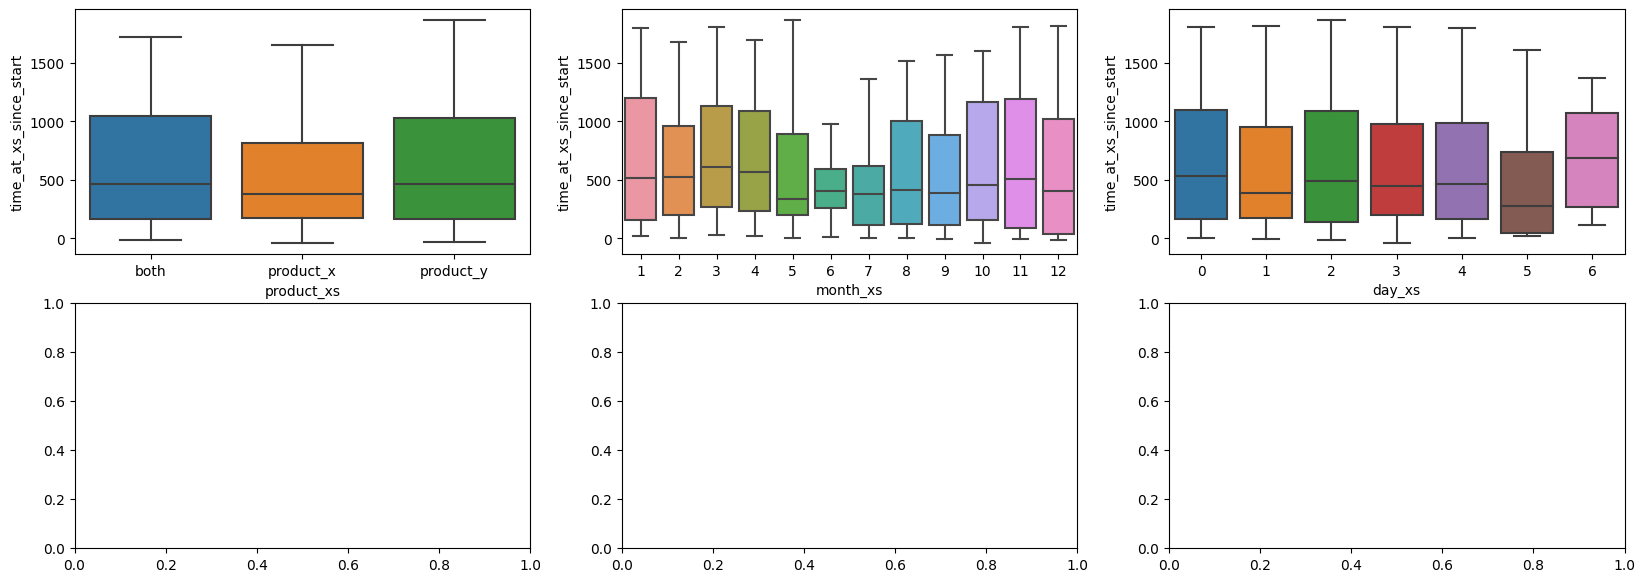

In [180]:
pu.box_plot_grid_x(data=df_xs_with_base, x_list=["product_xs", "month_xs", "day_xs"], y="time_at_xs_since_start", showfliers=False)

Analysis:

- product_x associated to a lower time to cross sell conversion
- month_xs June and July associated to a lower time to cross sell conversion
- day_xs Friday associated to a lower time to cross sell conversion

<a id='xs_cohort_analysis'></a>

#### 2.2.1 Identifying relevant customer cohorts based on historical cross sell CLV

Now let's have a look at different value cohorts within the cross sell dataset. We will divide the data into 3 cohorts, high value, mid value and low value, based on the quartiles of the clv_xs distribution and excluding outliers

In [181]:
Q1_xs = df_xs_with_base['clv_xs'].quantile(0.25)
Q2_xs = df_xs_with_base['clv_xs'].quantile(0.5)
Q3_xs = df_xs_with_base['clv_xs'].quantile(0.75)

# Calculate the IQR
IQR_xs = Q3_xs - Q1_xs

# Define the lower and upper bounds for outliers
lower_bound_xs = Q1_xs - 1.5 * IQR_xs
upper_bound_xs = Q3_xs + 1.5 * IQR_xs

# Detect outliers
outliers_high_xs = df_xs_with_base[(df_xs_with_base['clv_xs'] > upper_bound_xs)]
outliers_low_xs = df_xs_with_base[(df_xs_with_base['clv_xs'] < lower_bound_xs)]
outliers_xs = outliers_high_xs.append(outliers_low_xs)

We now define the non-outlier customer cohorts low, mid and high

In [182]:
#Define non-outlier xs cohorts

#Low: below 0.25 quartile
df_xs_with_base.loc[(df_xs_with_base['clv_xs'] >= lower_bound_xs) & (df_xs_with_base['clv_xs'] < Q1_xs), "cohort_xs"] = "low"

#Mid: between 0.25 and 0.75 quartiles
df_xs_with_base.loc[(df_xs_with_base['clv_xs'] >= Q1_xs) & (df_xs_with_base['clv_xs'] < Q3_xs), "cohort_xs"] = "mid"

#High: above 0.75 quartile
df_xs_with_base.loc[(df_xs_with_base['clv_xs'] >= Q3_xs) & (df_xs_with_base['clv_xs'] < upper_bound_xs), "cohort_xs"] = "high"

df_xs_with_base_cohorts = df_xs_with_base[df_xs_with_base["cohort_xs"].isnull()==False]

Let's start analyzing the high value cohort

In [183]:
df_xs_with_base_cohorts[df_xs_with_base_cohorts["cohort_xs"]=="high"][["commission","time_at_xs_since_start", "clv_12", "clv_xs"]].describe()

,commission,time_at_xs_since_start,clv_12,clv_xs
count,189.000000,189.000000,189.000000,189.000000
mean,13.684550,648.544974,164.214603,1252.035026
std,4.192288,527.604476,50.307454,204.435070
min,10.000000,-1.000000,120.000000,989.200000
25%,11.880000,179.000000,142.560000,1086.220000
50%,12.512500,509.000000,150.150000,1193.452500
75%,13.637500,1106.000000,163.650000,1372.977500
max,33.085000,1819.000000,397.020000,1783.592500


In [184]:
df_xs_with_base_cohorts[df_xs_with_base_cohorts["cohort_xs"]=="mid"][["commission","time_at_xs_since_start", "clv_12", "clv_xs"]].describe()

,commission,time_at_xs_since_start,clv_12,clv_xs
count,506.000000,506.000000,506.000000,506.000000
mean,13.524827,645.015810,161.223502,619.354694
std,4.369687,516.192062,52.806301,130.584084
min,10.000000,-12.000000,29.711589,448.390000
25%,11.677500,185.250000,140.130000,526.850000
50%,12.483750,488.000000,149.490000,563.618750
75%,13.447500,1062.000000,161.340000,708.288125
max,49.477500,1864.000000,593.730000,988.255000


In [185]:
df_xs_with_base_cohorts[df_xs_with_base_cohorts["cohort_xs"]=="low"][["commission","time_at_xs_since_start", "clv_12", "clv_xs"]].describe()

,commission,time_at_xs_since_start,clv_12,clv_xs
count,253.000000,253.000000,253.000000,253.000000
mean,14.132055,531.853755,167.637505,304.331206
std,4.446285,488.121194,54.406829,101.289472
min,10.000000,-40.000000,48.399534,10.000000
25%,11.965000,113.000000,143.580000,247.020000
50%,12.582500,397.000000,150.690000,300.305000
75%,13.680000,855.000000,164.160000,397.692500
max,35.975000,1807.000000,431.700000,446.607500


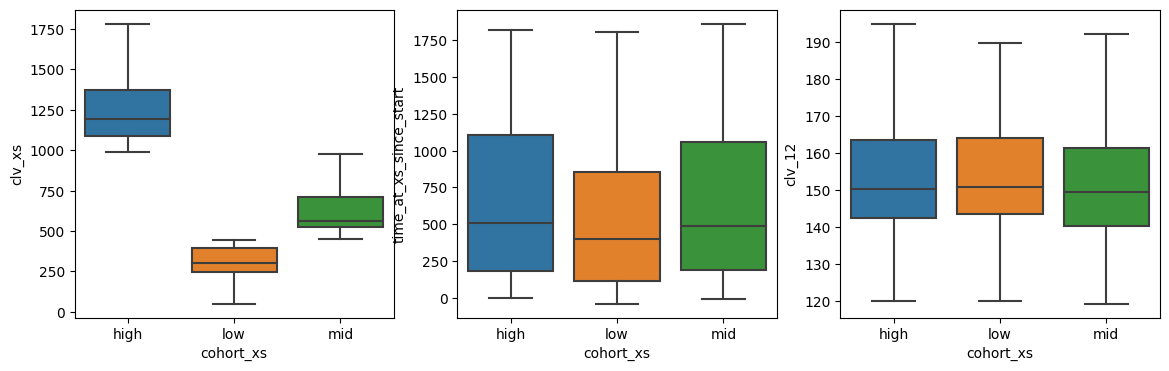

In [186]:
pu.box_plot_grid_y(df_xs_with_base_cohorts, "cohort_xs", ["clv_xs","time_at_xs_since_start","clv_12"], showfliers=False)

The low value cohort seems to be associated to a lower time to cross sell conversion than the other two. However, the clv_12 for the 3 cohorts looks quite similar

We will analyze an additional cohort that corresponds to user that don't convert to cross sell (i.e., we'll start tackling the first part of the problem we discussed above), as we also want to profile the customers that convert to cross sell vs the ones that don't

For these, we will locate some negative samples from the Customer Base data, i.e. observations of customers that did not convert to cross sell. We'll only extract observations with a customer_started_at time within the time window of the start times for the user ids in the cross sell data. We're assuming here that using the same time frame will ensure that the differences between the negative and positive samples will not be biased due to external factors (e.g. macroeconomic situation, promotional events, etc.). However, with additional and more specific knowledge of the data and the problem we could potentially come up with a better way of collecting negative samples

In [187]:
#Extract negative samples
users_xs = df_xs["user_id"].unique().tolist()
num_pos_samples = len(df_xs_with_base["user_id"].unique())
min_start_date_xs = df_xs_with_base["customer_started_at"].min()
max_start_date_xs = df_xs_with_base["customer_started_at"].max()

#We tried extracting the same number as num_pos_samples, however, there were no enough observations
#within the desired timeframe, so we just extracted all available data points
df_neg_samples = df_base_clv_non_neg[(df_base_clv_non_neg["user_id"].isin(users_xs)==False) & \
                    (df_base_clv_non_neg["customer_started_at"]>=min_start_date_xs) & \
                    (df_base_clv_non_neg["customer_started_at"]<=max_start_date_xs)].sample(n=num_pos_samples)
num_neg_samples = len(df_neg_samples)
df_neg_samples["how_long_customer"] = df_neg_samples["how_long_customer"].dt.total_seconds().astype(float)/(3600*24)
df_xs_with_base_cohorts["how_long_customer"] = df_xs_with_base_cohorts["how_long_customer"].dt.total_seconds().astype(float)/(3600*24)

print(f"We have extracted {num_neg_samples} negative samples")
print(f"We have {num_pos_samples} positive samples")

We have extracted 1012 negative samples
We have 1012 positive samples


/home/jupyter/venvs/gs/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [188]:
#Create no cross sell conversion label
df_neg_samples["cohort_xs"] = "no xs conversion"
df_xs_with_base_cohorts = df_xs_with_base_cohorts.append(df_neg_samples)

Analyze the general distribution of the continuous variables for the negative vs positive samples data

In [189]:
df_neg_samples[["commission","clv_12", "how_long_customer"]].describe()

,commission,clv_12,how_long_customer
count,1012.000000,1012.000000,1012.000000
mean,13.759523,133.179997,725.558300
std,5.503774,73.512028,514.320955
min,10.000000,0.000000,0.000000
25%,12.047500,120.000000,364.750000
50%,12.557500,146.100000,648.500000
75%,13.447500,155.100000,1065.000000
max,136.407500,1636.890000,2125.000000


In [193]:
df_xs_with_base_cohorts[df_xs_with_base_cohorts["cohort_xs"]!="no xs conversion"][["commission","clv_12", "how_long_customer"]].describe()

,commission,clv_12,how_long_customer
count,948.000000,948.000000,948.000000
mean,13.718726,163.531583,1010.953586
std,4.358666,52.769028,510.734494
min,10.000000,29.711589,40.000000
25%,11.770000,141.150000,558.750000
50%,12.555000,150.660000,884.500000
75%,13.447500,161.370000,1384.500000
max,49.477500,593.730000,2210.000000


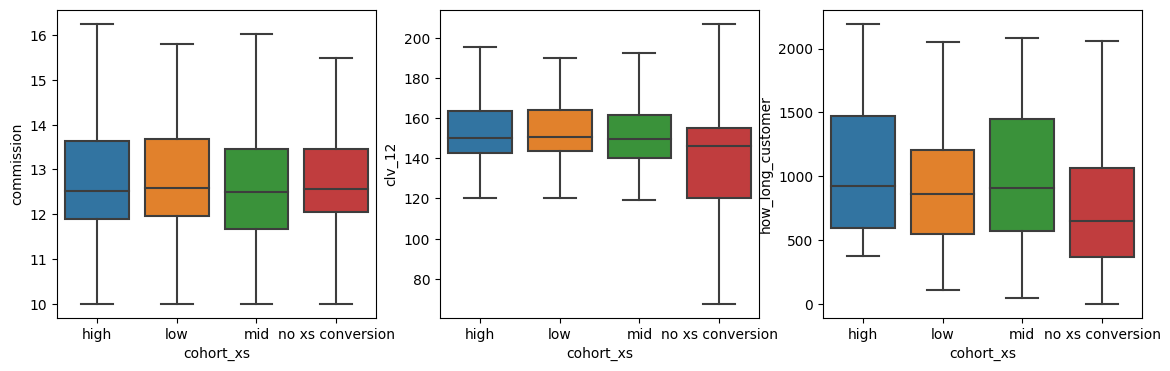

In [194]:
pu.box_plot_grid_y(df_xs_with_base_cohorts, "cohort_xs", ["commission","clv_12", "how_long_customer"], showfliers=False)

The customers without cross sell conversion are associated to a a lower clv_12 and a lower customer duration. The customers with low cross sell value are associated also to a lower customer duration vs the other 2 cross sell value cohorts

Now let's have a look at the distribution of the categorical variables for the different cross sell cohorts

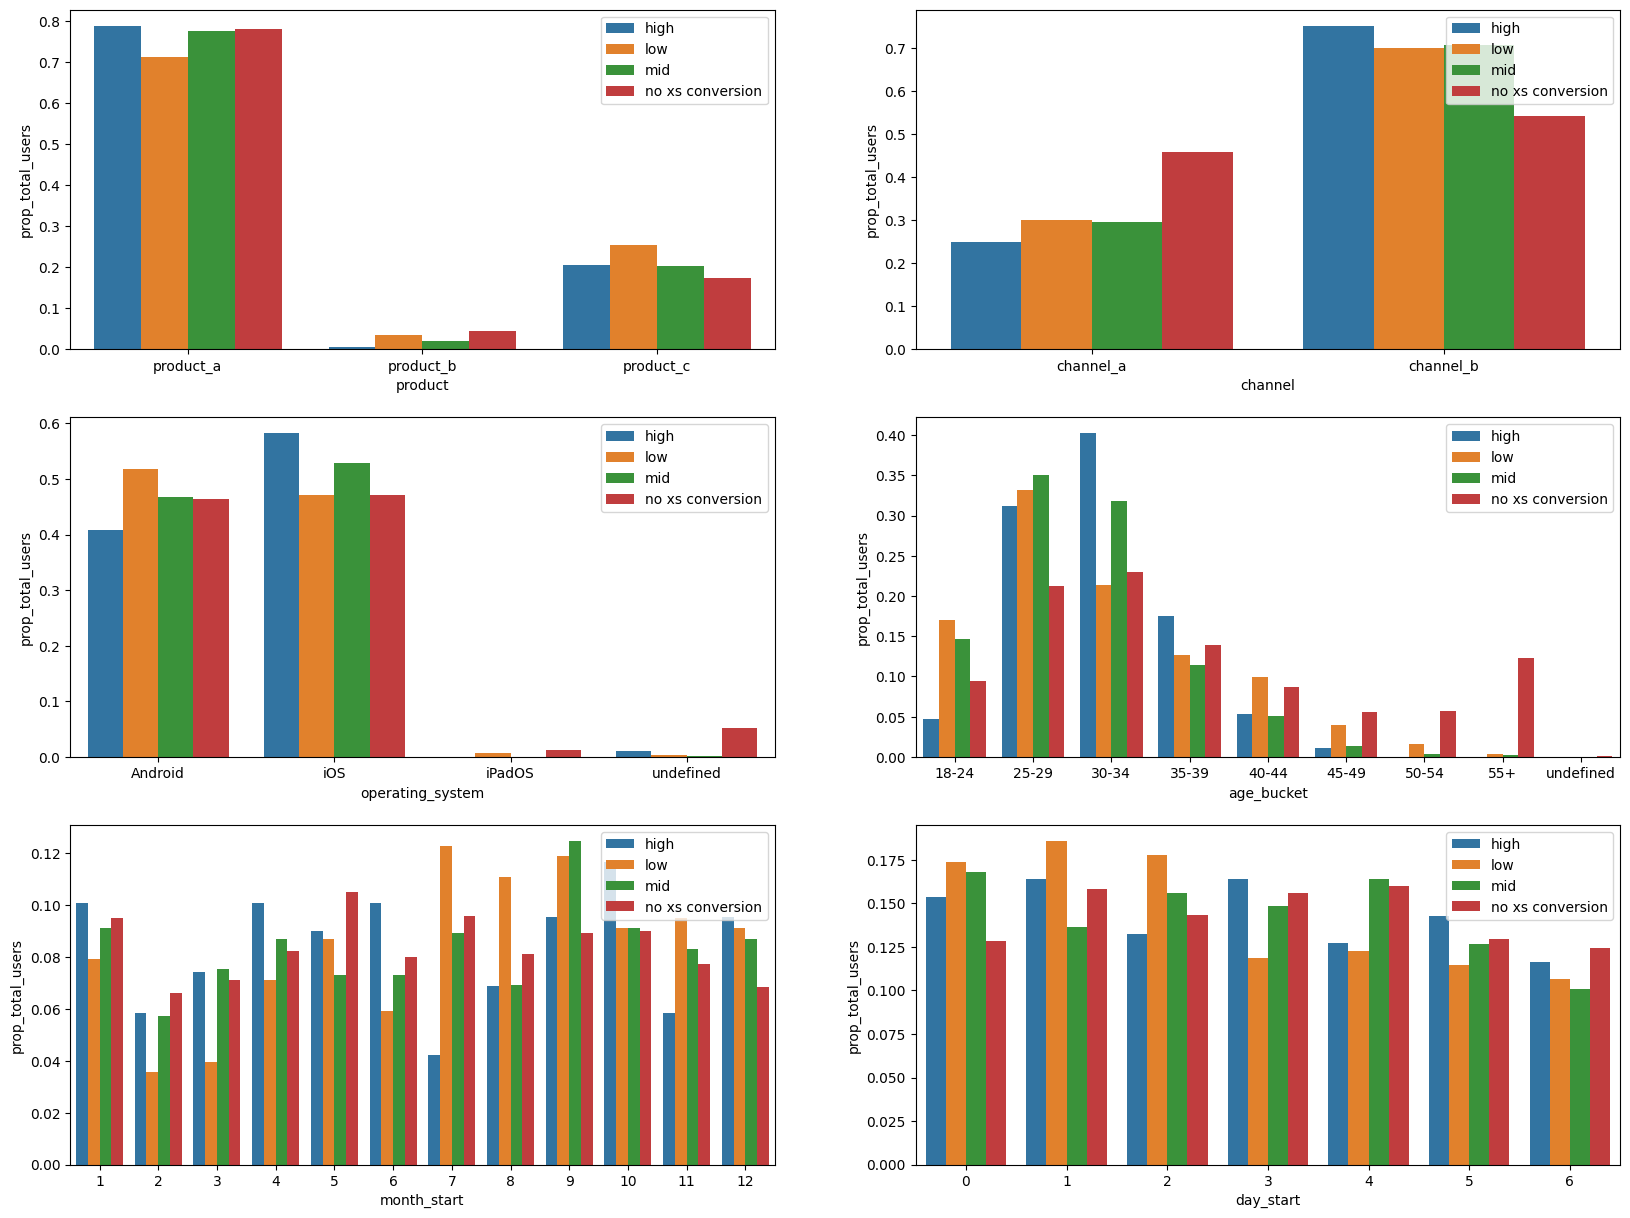

In [195]:
pu.barplot_grid(df_xs_with_base_cohorts, x_list=["product", "channel", "operating_system", "age_bucket", "month_start", "day_start"], y="user_id", hue="cohort_xs")

Analysis:
- product_c users are slightly less present in the no cross sell conversion group than in the other cohorts
- channel_a users are more proportionally present in the no cross sell conversion group
- operating_system undefined is more proportionally present in the no xs conversion group. iOS is more present in the high and mid cross sell value groups while Android is the most prevalent in the low cross sell value group
- age_bucket's >45 seem to be more proportionally present in the no cross sell conversion group, in particular 55+. Customers, in the 25-34 age range seem to be proportionally more present in the cross sell converted groups, with 30-34 most associated with high cross sell value
- customers starting on September and December are more proportionally present in the cross sell converted cohorts vs the no-conversion group
- user starting on Sunday are more proportionally present in the cross sell converted cohorts vs the no-conversion group